In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

plt.rcParams["figure.figsize"] = (6,3)
plt.rcParams["figure.figsize"] = (6,3)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"],
})

###########################################
# Paramètres
num_balls = 100
ball_radius = 0.09
box_size = 5
dt = 0.05
Nt = 200
Nimages= 200
##------------------------------------------
# Paramètres distribution Maxwell-Boltzmann
T = 0.12   # Température (kb = m = hbar = 1)
##------------------------------------------
flag_print = 0
###########################################

sigma = np.sqrt(T)

# Initialisation des positions et vitesses des balles
positions = np.random.rand(num_balls, 2) * box_size
# velocities = np.random.randn(num_balls, 2)
velocities = np.random.uniform(-1.0,1.0, (num_balls,2))
# velocities =  np.random.normal(0.0, sigma, (num_balls,2))    # Distribution de Maxwell Boltzmann (loi normale)


plt.figure()
plt.hist(np.rot90(velocities)[0],20,color = "goldenrod")
plt.show() 

plt.figure()
plt.hist(np.rot90(velocities)[1],20,color = "goldenrod")
plt.show()

if flag_print:
    print(positions)
    print(velocities)

# Création de la figure avec une taille fixe
fig, ax = plt.subplots(figsize=(4, 4))  # Taille de la figure : 6 pouces x 6 pouces
ax.set(xlim=(0, box_size), ylim=(0, box_size))
ax.set_xticks([])
ax.set_yticks([])
balls, = ax.plot([], [], 'o', color = "teal", ms=ball_radius*85)

# Ajout de la grille
# ax.grid(True)

# Dessiner la grille manuellement
for i in range(1, int(box_size)):
    ax.plot([i, i], [0, box_size], color='gray', linestyle='--')
    ax.plot([0, box_size], [i, i], color='gray', linestyle='--')

# Fonction d'initialisation de l'animation
def init():
    balls.set_data([], [])
    return balls,

# Fonction de mise à jour de l'animation
def update(frame):
    global velocities

    # Mise à jour des positions des balles en fonction de leurs vitesses
    old_positions = np.copy(positions)
    positions[:] += velocities * dt
    
    # Gestion des rebonds sur les bords de la boîte
    for i in range(num_balls):
        for j in range(2):
            if positions[i, j] < 0:
                positions[i, j] = box_size
            elif positions[i, j] > box_size:
                positions[i, j] = 0

    # Détection et gestion des collisions entre les balles
    for i in range(num_balls):
        for j in range(i + 1, num_balls):
            dist = np.linalg.norm(positions[i] - positions[j])
            if dist < 2*ball_radius:  # Collision détectée
                # Calcul du vecteur de collision et de l'impulsion
                direction = (positions[j] - positions[i]) / dist
                impulse = np.dot(velocities[j] - velocities[i], direction) * direction
                
                # Mise à jour des vitesses des balles en fonction de la collision
                velocities[i] += impulse
                velocities[j] -= impulse
                
#                 positions[i] = old_positions[i]
#                 positions[j] = old_positions[j]

#     # Mise à jour des positions des balles en fonction de leurs vitesses
#     positions[:] += velocities * dt

    # Mise à jour de la position des balles dans l'animation
    balls.set_data(positions[:, 0], positions[:, 1])
    return balls,

# Création de l'animation
ani = FuncAnimation(fig, update, frames=np.arange(0,Nimages), init_func=init, blit=True, interval = 1000)

# Enregistrement de l'animation en tant que GIF
ani.save('collision_animation_2D_grille.gif', writer='imagemagick', fps = 24, dpi = 200)

# Affichage de l'animation
plt.show()

plt.figure()
plt.hist(np.rot90(velocities)[0], 20,color = "goldenrod")
plt.show() 

plt.figure()
plt.hist(np.rot90(velocities)[1],20,color = "goldenrod")
plt.show()


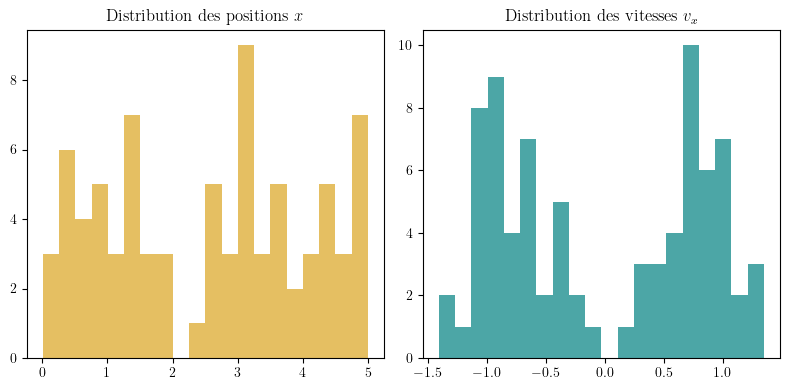

✅ Animation enregistrée : outputs/positions_animation.mp4
Moment d’ordre 2 : 0.7986195060627335


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"],
    "figure.figsize": (5, 5)
})


# ================================================================
# 🔹 1. Classe ParticleSystem : dynamique et intégration
# ================================================================
class ParticleSystem:
    def __init__(self, num_balls=100, box_size=5, ball_radius=0.09, dt=0.05, T=0.12):
        self.num_balls = num_balls
        self.box_size = box_size
        self.ball_radius = ball_radius
        self.dt = dt
        self.T = T

        # États
        self.positions = np.zeros((num_balls, 2))
        self.velocities = np.zeros((num_balls, 2))

    # --------------------
    # Initialisations
    # --------------------
    def init_positions(self, mode="uniform", centers=None, sigmas=None):
        if mode == "uniform":
            self.positions = np.random.rand(self.num_balls, 2) * self.box_size
        elif mode == "gaussian":
            if centers is None:
                centers = [self.box_size / 2, self.box_size / 2]
            if sigmas is None:
                sigmas = [1, 1]
            self.positions = np.random.normal(centers, sigmas, (self.num_balls, 2))
        elif mode == "double_gaussian":
            half = self.num_balls // 2
            self.positions[:half] = np.random.normal([1.5, 2.5], [0.3, 0.3], (half, 2))
            self.positions[half:] = np.random.normal([3.5, 2.5], [0.3, 0.3], (self.num_balls - half, 2))
        else:
            raise ValueError(f"Mode de position '{mode}' inconnu.")

    def init_velocities(self, mode="maxwell", sigma=None, means=None):
        if mode == "uniform":
            self.velocities = np.random.uniform(-1.0, 1.0, (self.num_balls, 2))
        elif mode == "maxwell":
            sigma = np.sqrt(self.T) if sigma is None else sigma
            self.velocities = np.random.normal(0.0, sigma, (self.num_balls, 2))
        elif mode == "double_gaussian":
            half = self.num_balls // 2
            mean1, mean2 = (means or [[-0.8, 0], [0.8, 0]])
            sigma = sigma or [0.3, 0.3]
            self.velocities[:half] = np.random.normal(mean1, sigma, (half, 2))
            self.velocities[half:] = np.random.normal(mean2, sigma, (self.num_balls - half, 2))
        else:
            raise ValueError(f"Mode de vitesse '{mode}' inconnu.")

    # --------------------
    # Mise à jour temporelle
    # --------------------
    def update(self):
        self.positions += self.velocities * self.dt

        # Bords périodiques
        self.positions %= self.box_size

        # Collisions simples (élastiques)
        for i in range(self.num_balls):
            for j in range(i + 1, self.num_balls):
                diff = self.positions[i] - self.positions[j]
                dist = np.linalg.norm(diff)
                if dist < 2 * self.ball_radius:
                    direction = diff / dist
                    dv = self.velocities[i] - self.velocities[j]
                    impulse = np.dot(dv, direction) * direction
                    self.velocities[i] -= impulse
                    self.velocities[j] += impulse


# ================================================================
# 🔹 2. Classe PhysicalAnalysis : étude physique
# ================================================================
class PhysicalAnalysis:
    def __init__(self, system: ParticleSystem):
        self.system = system

    def compute_moments(self, order=2):
        """Retourne les moments d'ordre donné sur les vitesses."""
        v = np.linalg.norm(self.system.velocities, axis=1)
        return np.mean(v ** order)

    def plot_histograms(self, save_dir=None):
        """Histogrammes des positions et vitesses."""
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].hist(self.system.positions[:, 0], bins=20, color="goldenrod", alpha=0.7)
        axes[0].set_title("Distribution des positions $x$")
        axes[1].hist(self.system.velocities[:, 0], bins=20, color="teal", alpha=0.7)
        axes[1].set_title("Distribution des vitesses $v_x$")
        plt.tight_layout()

        if save_dir:
            plt.savefig(os.path.join(save_dir, "histograms.png"), dpi=200)
        plt.show()


# ================================================================
# 🔹 3. Classe AnimationManager : sauvegarde & rendu
# ================================================================
class AnimationManager:
    def __init__(self, system: ParticleSystem, output_dir="outputs"):
        self.system = system
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def animate_positions(self, n_frames=200, fps=24, fmt="gif"):
        fig, ax = plt.subplots()
        ax.set_xlim(0, self.system.box_size)
        ax.set_ylim(0, self.system.box_size)
        ax.set_xticks([]); ax.set_yticks([])
        scat, = ax.plot([], [], 'o', color='teal', ms=self.system.ball_radius * 85)

        def init():
            scat.set_data([], [])
            return scat,

        def update(frame):
            self.system.update()
            scat.set_data(self.system.positions[:, 0], self.system.positions[:, 1])
            return scat,

        ani = FuncAnimation(fig, update, frames=n_frames, init_func=init, blit=True, interval=50)

        file_path = os.path.join(self.output_dir, f"positions_animation.{fmt}")
        if fmt == "gif":
            ani.save(file_path, writer="imagemagick", fps=fps, dpi=200)
        elif fmt == "mp4":
            ani.save(file_path, writer="ffmpeg", fps=fps, dpi=200)

        plt.close(fig)
        print(f"✅ Animation enregistrée : {file_path}")


# ================================================================
# 🔹 Exemple d’utilisation
# ================================================================
if __name__ == "__main__":
    system = ParticleSystem(num_balls=80, T=0.1)
    system.init_positions(mode="uniform")
    system.init_velocities(mode="double_gaussian")

    analysis = PhysicalAnalysis(system)
    manager = AnimationManager(system)

    analysis.plot_histograms()
    manager.animate_positions(fmt="mp4")
    print("Moment d’ordre 2 :", analysis.compute_moments(order=2))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os
import json

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"],
    "figure.figsize": (5, 5)
})


# ================================================================
# 🔹 1. Classe : système de particules
# ================================================================
import numpy as np

class ParticleSystem:
    def __init__(self, num_balls=100, box_size=5, ball_radius=0.09, dt=0.01, T=0.12, max_init_attempts=5000):
        self.num_balls = num_balls
        self.box_size = box_size
        self.ball_radius = ball_radius
        self.dt = dt
        self.T = T
        self.max_init_attempts = max_init_attempts

        self.positions = np.zeros((num_balls, 2))
        self.velocities = np.zeros((num_balls, 2))
        self.history_positions = []
        self.history_velocities = []

    # ==============================================================
    # 🔹 Initialisation des positions sans recouvrement
    # ==============================================================
    def init_positions(self, mode="uniform"):
        positions = []
        min_dist = 2 * self.ball_radius

        for n in range(self.num_balls):
            for attempt in range(self.max_init_attempts):
                if mode == "uniform":
                    candidate = np.random.rand(2) * self.box_size
                elif mode == "double_gaussian":
                    if n < self.num_balls // 2:
                        candidate = np.random.normal([1.5, 2.5], [0.3, 0.3])
                    else:
                        candidate = np.random.normal([3.5, 2.5], [0.3, 0.3])
                else:
                    raise ValueError(f"Mode inconnu : {mode}")

                # Vérifie la distance avec toutes les particules déjà placées
                if all(np.linalg.norm(candidate - p) >= min_dist for p in positions):
                    positions.append(candidate)
                    break
            else:
                raise RuntimeError(f"Impossible de placer la particule {n} sans chevauchement après {self.max_init_attempts} essais")

        self.positions = np.array(positions)

    # ==============================================================
    # 🔹 Initialisation des vitesses
    # ==============================================================
    def init_velocities(self, mode="double_gaussian"):
        if mode == "uniform":
            self.velocities = np.random.uniform(-1.0, 1.0, (self.num_balls, 2))
        elif mode == "maxwell":
            sigma = np.sqrt(self.T)
            self.velocities = np.random.normal(0.0, sigma, (self.num_balls, 2))
        elif mode == "double_gaussian":
            half = self.num_balls // 2
            sigma = 1.0
            self.velocities[:half] = np.random.normal([-2.8, 0], [sigma, sigma], (half, 2))
            self.velocities[half:] = np.random.normal([2.8, 0], [sigma, sigma], (self.num_balls - half, 2))
        else:
            raise ValueError(f"Mode inconnu : {mode}")

    # ==============================================================
    # 🔹 Mise à jour avec correction d'interpénétration
    # ==============================================================
    def update(self):
        """Mise à jour du système à chaque pas de temps."""
        self.positions += self.velocities * self.dt
        self.positions %= self.box_size  # bords périodiques
        self._handle_collisions()
        self.history_positions.append(np.copy(self.positions))
        self.history_velocities.append(np.copy(self.velocities))

    # ==============================================================
    # 🔹 Collisions élastiques avec correction géométrique
    # ==============================================================
    def _handle_collisions(self):
        for i in range(self.num_balls):
            for j in range(i + 1, self.num_balls):
                diff = self.positions[i] - self.positions[j]
                dist = np.linalg.norm(diff)

                if dist < 2 * self.ball_radius and dist > 0:
                    direction = diff / dist
                    dv = self.velocities[i] - self.velocities[j]
                    v_rel = np.dot(dv, direction)

                    # Collision seulement si les particules se rapprochent
                    if v_rel < 0:
                        impulse = v_rel * direction
                        self.velocities[i] -= impulse
                        self.velocities[j] += impulse

                        # Correction géométrique : repositionner les particules sans recouvrement
                        overlap = 2 * self.ball_radius - dist
                        correction = direction * (overlap / 2)
                        self.positions[i] += correction
                        self.positions[j] -= correction



# ================================================================
# 🔹 2. Classe : sauvegarde & chargement des données
# ================================================================
class SimulationRecorder:
    def __init__(self, system: ParticleSystem, output_dir="outputs"):
        self.system = system
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def save_data(self):
        """Sauvegarde toutes les données de la simulation."""
        np.savez(
            os.path.join(self.output_dir, "simulation_data.npz"),
            positions=np.array(self.system.history_positions),
            velocities=np.array(self.system.history_velocities)
        )
        with open(os.path.join(self.output_dir, "params.json"), "w") as f:
            json.dump({
                "num_balls": self.system.num_balls,
                "box_size": self.system.box_size,
                "ball_radius": self.system.ball_radius,
                "dt": self.system.dt,
                "T": self.system.T
            }, f, indent=4)
        print("✅ Données sauvegardées dans", self.output_dir)

    @staticmethod
    def load_data(input_dir="outputs"):
        """Charge les données enregistrées pour rejouer ou analyser."""
        data = np.load(os.path.join(input_dir, "simulation_data.npz"))
        with open(os.path.join(input_dir, "params.json")) as f:
            params = json.load(f)
        return data, params


# ================================================================
# 🔹 3. Classe : étude physique
# ================================================================
class PhysicalAnalysis:
    def __init__(self, positions, velocities):
        self.positions = positions
        self.velocities = velocities

    def compute_moments(self, order=2):
        v = np.linalg.norm(self.velocities, axis=2)
        return np.mean(v**order, axis=1)

    def animate_moments(self, output_dir="outputs", fps=20 ):
        fig, ax = plt.subplots()
        orders = [0, 1, 2, 3]
        lines = [ax.plot([], [], label=f"Ordre {n}")[0] for n in orders]
        ax.set_xlim(0, len(self.positions))
        ax.set_ylim(0, None)
        ax.legend()
        ax.set_title("Évolution des moments selon le temps")

        moments = [self.compute_moments(order=n) for n in orders]

        #print(moments)

        def update(frame):
            for n, line in enumerate(lines):
                line.set_data(np.arange(frame), moments[n][:frame])
            return lines

        ani = FuncAnimation(fig, update, frames=len(self.positions), blit=True, interval=100)
        ani.save(os.path.join(output_dir, "moments_evolution.mp4"), writer="ffmpeg", fps=fps)
        plt.close(fig)
        print("🎞️ Animation moments enregistrée.")


# ================================================================
# 🔹 4. Classe : animation visuelle
# ================================================================
class AnimationManager:
    def __init__(self, system: ParticleSystem, output_dir="outputs"):
        self.system = system
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def animate_positions(self, n_frames=200, fps=24, fmt="mp4", show_grid=True):
        fig, ax = plt.subplots()
        ax.set_xlim(0, self.system.box_size)
        ax.set_ylim(0, self.system.box_size)
        ax.set_xticks([]); ax.set_yticks([])

        # Ajout de la grille manuelle
        if show_grid:
            for i in range(1, int(self.system.box_size)):
                ax.plot([i, i], [0, self.system.box_size], color='gray', linestyle='--', lw=0.5)
                ax.plot([0, self.system.box_size], [i, i], color='gray', linestyle='--', lw=0.5)

        scat, = ax.plot([], [], 'o', color='teal', ms=self.system.ball_radius * 85)

        def init():
            scat.set_data([], [])
            return scat,

        def update(frame):
            self.system.update()
            scat.set_data(self.system.positions[:, 0], self.system.positions[:, 1])
            return scat,

        ani = FuncAnimation(fig, update, frames=n_frames, init_func=init, blit=True, interval=50)
        path = os.path.join(self.output_dir, f"positions_animation.{fmt}")
        ani.save(path, writer="ffmpeg", fps=fps, dpi=200)
        plt.close(fig)
        print("🎞️ Animation positions enregistrée :", path)

    def animate_velocity_distribution(self, fps=24):
        fig, ax = plt.subplots()
        ax.set_xlim(-4, 4)
        ax.set_ylim(0, 50)
        ax.set_title("Distribution des vitesses $v_x$")
        bars = ax.hist([], bins=20, color='goldenrod', alpha=0.7)[2]

        def update(frame):
            vxs = self.system.history_velocities[frame][:, 0]
            ax.cla()
            ax.hist(vxs, bins=20, color='goldenrod', alpha=0.7)
            ax.set_xlim(-4, 4)
            ax.set_ylim(0, 50)
            ax.set_title(f"Distribution des vitesses — frame {frame}")
            return bars

        ani = FuncAnimation(fig, update, frames=len(self.system.history_velocities), interval=100)
        ani.save(os.path.join(self.output_dir, "velocity_distribution.mp4"), writer="ffmpeg", fps=fps)
        plt.close(fig)
        print("🎞️ Animation distribution vitesses enregistrée.")
        

# ================================================================
# 🔹 5. Exemple d’utilisation
# ================================================================
if __name__ == "__main__":
    system = ParticleSystem(num_balls=100, T=10.0)
    system.init_positions("uniform")
    system.init_velocities("double_gaussian")

    anim = AnimationManager(system)
    anim.animate_positions(n_frames=1000, fmt="mp4")
    anim.animate_velocity_distribution(fps=24)

    recorder = SimulationRecorder(system)
    recorder.save_data()

    data, _ = SimulationRecorder.load_data()
    analysis = PhysicalAnalysis(data["positions"], data["velocities"])
    analysis.animate_moments()


🎞️ Animation positions enregistrée : outputs/positions_animation.mp4


In [23]:
import numpy as np

# Charger le fichier
data = np.load('./outputs/simulation_data.npz')

# Afficher la liste des tableaux contenus dans le fichier
print("Clés disponibles :", data.files)

# Afficher le contenu de chaque tableau
for key in data.files:
    print(f"\n--- {key} ---")
    print(data[key])
    print("Shape :", data[key].shape)


Clés disponibles : ['positions', 'velocities']

--- positions ---
[[[3.07946416 0.72870207]
  [0.20809058 0.0896084 ]
  [4.10384046 4.92025373]
  ...
  [0.3293179  1.08049396]
  [1.49830406 1.4843151 ]
  [1.56750113 4.72062685]]

 [[3.03997323 0.73096318]
  [0.17497365 0.06156392]
  [4.075229   4.9309374 ]
  ...
  [0.34661424 1.06424023]
  [1.52344629 1.48094396]
  [1.59842027 4.73215093]]

 [[3.01061131 0.70088568]
  [0.14185673 0.03351943]
  [4.04661753 4.94162108]
  ...
  [0.35295878 1.07109826]
  [1.54858851 1.47757281]
  [1.62933941 4.74367502]]

 ...

 [[2.77986853 2.39841298]
  [0.63897166 2.41990036]
  [4.68002885 0.1384832 ]
  ...
  [1.41801486 3.89630642]
  [1.50327316 3.38767822]
  [3.88431494 1.97040391]]

 [[2.77865675 2.40643681]
  [0.64254578 2.40737753]
  [4.67303627 0.15772528]
  ...
  [1.40229117 3.91467823]
  [1.52057643 3.38585187]
  [3.89265072 2.01868142]]

 [[2.77744497 2.41446063]
  [0.64611989 2.3948547 ]
  [4.66604369 0.17696735]
  ...
  [1.38656748 3.93305004